In [10]:
import sys
sys.path.append("../../gaia_tools/")
sys.path.append("../../scripts/")
import covariance_generation as cov
from mcmc_plots import *
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from pylab import *
from scipy.optimize import curve_fit
from cProfile import label
import pandas as pd

In [2]:
from scipy.stats import linregress
def get_curve_slope(vc, R):
    print(vc)
    linear_reg_result = linregress(np.array(R), np.abs(vc))
    return linear_reg_result

In [44]:
# Rotation Curve Plotting Function

def plot_rotation_curve(mcmc_runs, 
                        labels, 
                        burnin, 
                        extra_dims=[], 
                        display_eilers=False, 
                        display_bin_edges=False,
                        is_last_merged=False,
                        ):


    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'red', 'blue', 'green', 'orange']
    

    if(is_last_merged):
        new_bin_center = (bin_centers_r[-2] + bin_centers_r[-1])/2
        bin_centers_r = np.delete(bin_centers_r, -1)
        bin_centers_r[-1] = new_bin_center

    mcmc_fmts = ['o', 'd', 'd', 'x', 'x']
    for i_path, path in enumerate(mcmc_runs):
        bin_setup = load_bin_settings(mcmc_runs[i_path], is_print=False)
        bin_centers_r = bin_setup['bin_centers_r']

        if(i_path > 0):
            bin_centers_r = bin_centers_r/8.277*8.178

        path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin[i_path])
        flatchain = reader.get_chain(flat=True, discard = burnin[i_path])

        bin_velocities = []
        ndim = samples_data.shape[2]

        if(len(extra_dims) > 0):
            ndim = samples_data.shape[2] - extra_dims[i_path]
        
        print('R, v_c, sig-, sig+')
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            v_med = np.median(flatchain[:, i])
            bin_velocities.append((v_med, v_sub, v_sup))

            print("{} {} {} {}".format(round(bin_centers_r[i]/1e3, 2) ,-round(v_mean,1), round(v_sub,1), round(v_sup, 1)))
        velocity_array = np.array(bin_velocities)

        # Get and print curve slope
        print(velocity_array)
        linear_reg_result = get_curve_slope(velocity_array[:,0], bin_centers_r)
        print(linear_reg_result)

        if(len(mcmc_runs) == 0):
            x_offset = 0
            x_values = bin_centers_r + x_offset
        else:
            x_offset = np.linspace(-500, 500, len(mcmc_runs))
            x_values = bin_centers_r + x_offset[i_path]
        y_values = velocity_array[:,0]
        y_error = [velocity_array[:,1], velocity_array[:,2]]

        print(x_values.shape)
        print(y_values.shape)

        
        plt.errorbar(x_values, -y_values,
                    yerr= y_error,
                    fmt=mcmc_fmts[i_path], 
                    c=colors[i_path], 
                    label=labels[i_path], 
                    markersize = 8)
        
        bin_edges_r = bin_setup['bin_edges'][0][0]
        if(display_bin_edges):
            if(is_last_merged):
                # Remove middle boundary
                bin_edges_r = np.delete(bin_edges_r, -2)

            if(i_path > 0): continue
            ax.vlines(bin_edges_r, 150, 255, linestyles='dashed', alpha=0.5, colors=colors[i_path])   
            #x_ticks = np.round(bin_edges_r)
            #ax.set_xticks(x_ticks)

    plt.xlabel(r'$R$ [kpc]', fontdict={'fontsize' : 16})
    plt.ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(fmt)


    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    ax.xaxis.set_major_locator(MultipleLocator(2*1e3))
    ax.yaxis.set_major_locator(MultipleLocator(10))

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())


    lit_fmts = ['+', 'x', '^', 'v', '.', '0']
    lit_fmts = ['^', 'v', '.', '+', 'x', 'o']
    lit_colors = ['blue', 'green', 'brown', 'orange', 'grey', 'red']
    lit_colors = ['brown', 'orange', 'grey', 'blue', 'green', 'red']
    if(display_eilers):
        for i, key in enumerate(other_curves_dict.keys()):
            print(key)
            rc_data = other_curves_dict[key]
            rc_data = rc_data[rc_data.R <= 26]

            rc_y_values = np.array(rc_data.v_c)
            rc_x_values = np.array(rc_data.R*1e3)

            print(rc_x_values)
            
            if((key == 'Eilers et al. 2018') or (key == 'Ou et al. 2023')):
                print(key)
                print(rc_data.columns)
                rc_y_error = [np.array(rc_data.sig_below), np.array(rc_data.sig_above)]
            else:
                rc_y_error = [np.array(rc_data.sig), np.array(rc_data.sig)]

            plt.errorbar(rc_x_values, rc_y_values, 
                    yerr=rc_y_error, 
                    fmt=lit_fmts[i],
                    color = lit_colors[i],
                    label=key, alpha=0.6)

    plt.legend(prop={'size': 9}, ncol=2, columnspacing=3)

    #h_lines  = np.arange(210, 251, 10)
    #ax.hlines(h_lines, 4500, 15500, linestyles='dashed', alpha=0.5, colors='grey')
     
    plt.xlim(4000, 25500)
    plt.rcParams["axes.grid"] = False

    return x_values, velocity_array



def load_bin_settings(folder_path, is_print=False):
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        data = handle.read()
    bin_setup = pickle.loads(data)

    if(is_print):
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))

    return bin_setup

In [40]:
# Rotation Curve Plotting Function

def plot_rotation_curve_delta_unc(mcmc_runs, 
                        labels, 
                        burnin, 
                        extra_dims=[], 
                        display_eilers=False, 
                        display_bin_edges=False,
                        is_last_merged=False,
                        ):

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, axs = plt.subplots(1, 1, figsize=(12, 6), sharey=False, sharex=True)
    divider = make_axes_locatable(axs)
    # Create ratio axes
    ax2 = divider.append_axes("bottom", size='40%', pad=0.15)
    axs.figure.add_axes(ax2)

    # fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'red', 'blue', 'green', 'orange']
    

    if(is_last_merged):
        new_bin_center = (bin_centers_r[-2] + bin_centers_r[-1])/2
        bin_centers_r = np.delete(bin_centers_r, -1)
        bin_centers_r[-1] = new_bin_center

    velocity_container_for_unc = []

    mcmc_fmts = ['o', 'd', 'd', 'x', 'x']
    for i_path, path in enumerate(mcmc_runs):
        bin_setup = load_bin_settings(mcmc_runs[i_path], is_print=False)
        bin_centers_r = bin_setup['bin_centers_r']

        if(i_path > 0):
            bin_centers_r = bin_centers_r/8.277*8.178

        path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin[i_path])
        flatchain = reader.get_chain(flat=True, discard = burnin[i_path])

        bin_velocities = []
        ndim = samples_data.shape[2]

        if(len(extra_dims) > 0):
            ndim = samples_data.shape[2] - extra_dims[i_path]
        
        print('R, v_c, sig-, sig+')
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            v_med = np.median(flatchain[:, i])
            bin_velocities.append((v_med, v_sub, v_sup))

            print("{} {} {} {}".format(round(bin_centers_r[i]/1e3, 2) ,-round(v_mean,1), round(v_sub,1), round(v_sup, 1)))
        velocity_array = np.array(bin_velocities)
        velocity_container_for_unc.append(velocity_array)

        # Get and print curve slope
        print(velocity_array)
        linear_reg_result = get_curve_slope(velocity_array[:,0], bin_centers_r)
        print(linear_reg_result)

        if(len(mcmc_runs) == 0):
            x_offset = 0
            x_values = bin_centers_r + x_offset
        else:
            x_offset = np.linspace(-300, 300, len(mcmc_runs))
            x_values = bin_centers_r + x_offset[i_path]
        y_values = velocity_array[:,0]
        y_error = [velocity_array[:,1], velocity_array[:,2]]

        print(x_values.shape)
        print(y_values.shape)

        
        axs.errorbar(x_values, -y_values,
                    yerr= y_error,
                    fmt=mcmc_fmts[i_path], 
                    c=colors[i_path], 
                    label=labels[i_path], 
                    markersize = 8)
        
        bin_edges_r = bin_setup['bin_edges'][0][0]
        if(display_bin_edges):
            if(is_last_merged):
                # Remove middle boundary
                bin_edges_r = np.delete(bin_edges_r, -2)

            if(i_path > 0): continue
            axs.vlines(bin_edges_r, 150, 255, linestyles='dashed', alpha=0.5, colors=colors[i_path])   
            #x_ticks = np.round(bin_edges_r)
            #ax.set_xticks(x_ticks)

    axs.legend()

    ax2.set_xlabel(r'$R$ [kpc]', fontdict={'fontsize' : 16})
    axs.set_ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})

    axs.tick_params(axis='both', which='major', labelsize=10)
    axs.tick_params(axis='both', which='minor', labelsize=8)

    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.tick_params(axis='both', which='minor', labelsize=8)

    ax2.set_xticks([0, 0.025, 0.05])

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax2.xaxis.set_major_formatter(fmt)


    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    axs.set_xticks([])
    ax2.xaxis.set_major_locator(MultipleLocator(2*1e3))
    axs.yaxis.set_major_locator(MultipleLocator(10))

    ax2.xaxis.set_minor_locator(AutoMinorLocator())
    axs.yaxis.set_minor_locator(AutoMinorLocator())



    lit_fmts = ['+', 'x', '^', 'v', '.', '0']
    lit_fmts = ['^', 'v', '.', '+', 'x', 'o']
    lit_colors = ['blue', 'green', 'brown', 'orange', 'grey', 'red']
    lit_colors = ['brown', 'orange', 'grey', 'blue', 'green', 'red']
    if(display_eilers):
        for i, key in enumerate(other_curves_dict.keys()):
            print(key)
            rc_data = other_curves_dict[key]
            rc_data = rc_data[rc_data.R <= 26]

            rc_y_values = np.array(rc_data.v_c)
            rc_x_values = np.array(rc_data.R*1e3)

            print(rc_x_values)
            
            if((key == 'Eilers et al. 2018') or (key == 'Ou et al. 2023')):
                print(key)
                print(rc_data.columns)
                rc_y_error = [np.array(rc_data.sig_below), np.array(rc_data.sig_above)]
            else:
                rc_y_error = [np.array(rc_data.sig), np.array(rc_data.sig)]

            axs.errorbar(rc_x_values, rc_y_values, 
                    yerr=rc_y_error, 
                    fmt=lit_fmts[i],
                    color = lit_colors[i],
                    label=key, alpha=0.6)

    axs.legend(prop={'size': 9}, ncol=2, columnspacing=3)

    #h_lines  = np.arange(210, 251, 10)
    #ax.hlines(h_lines, 4500, 15500, linestyles='dashed', alpha=0.5, colors='grey')
     
    axs.set_xlim(4000, 25500)
    ax2.set_xlim(4000, 25500)
    plt.rcParams["axes.grid"] = False


    # ax2 figure

    Ou_unc_data_path = '/home/sven/repos/gaia-tools/jupyter-notebook/xo_data_nbs/uncertainties_Ou.dat'
    Ou_unc_data = pd.read_csv(Ou_unc_data_path, skiprows=2, names=['R', 'Delta'], delimiter='    ')


    x_ou = Ou_unc_data.R
    y_ou = Ou_unc_data.Delta

    ax2.plot(x_ou*1e3, y_ou, label='Ou et al.', color='red', alpha=0.6)

    for k, velocity_array in enumerate(velocity_container_for_unc):
        deta_Ou_sample = (velocity_array[:, 1] + velocity_array[:, 2])/np.abs(velocity_array[:,0])
        ax2.plot(x_values, deta_Ou_sample, color=colors[k], label=labels[k])

    ax2.set_ylabel(r'$\Delta_{sys}/V_c$',  fontdict={'fontsize' : 16})
    ax2.legend()
    ax2.set_ylim(0, 0.1)

    return x_values, velocity_array



def load_bin_settings(folder_path, is_print=False):
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        data = handle.read()
    bin_setup = pickle.loads(data)

    if(is_print):
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))

    return bin_setup

## Figure 1: Ou et al. sample (Poder code) vs Distance Modulations of it

In [5]:
# Curves from literature

headers = ['R', 'v_c', 'sig']
cepheids_pm_method = pd.read_csv("../others_curves/cepheids_ablimit_1.dat", sep='  ', names=headers, skiprows=2, engine='python')
cepheids_vel_method = pd.read_csv("../others_curves/cepheids_ablimit_2.dat", sep='  ', names=headers, skiprows=2,  engine='python')
vc_data_wang = pd.read_csv("../others_curves/vcdata_wang+2022.dat", sep='  ', names=headers, skiprows=3, engine='python')
vc_zhou = pd.read_csv("../others_curves/vc_zhou_etal.csv", sep=' ', names=headers, skiprows=0, index_col=False, engine='python')

headers = ['R', 'v_c', 'sig_below', 'sig_above']
eilers_rc = pd.read_csv("../others_curves/Eilers_RC_Data.csv", sep=' ', names=headers)
ou_rc = pd.read_csv("/home/sven/repos/gaia-tools/jupyter-notebook/others_curves/vc_Ou.csv", sep=',')

other_curves_dict = {'Ablimit et al. 2020 - \nproper motion method' : cepheids_pm_method,
                    'Ablimit et al. 2020 - \n3D velocity method' : cepheids_vel_method,
                    'Wang et al. 2022' : vc_data_wang,
                    'Eilers et al. 2018' : eilers_rc,
                    'Zhou et al. 2022' : vc_zhou}

other_curves_dict = {
                    'Wang et al. 2022' : vc_data_wang,
                    'Eilers et al. 2018' : eilers_rc,
                    'Zhou et al. 2022' : vc_zhou,
                    'Ablimit et al. 2020 - \nproper motion method' : cepheids_pm_method,
                    'Ablimit et al. 2020 - \n3D velocity method' : cepheids_vel_method}

In [16]:

# TRUE DISTANCE
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-01-05-14-11-54_48_OU_run'

# DIFFERENT MODULATIONS
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-02-28-12-22-02_48_OU_run_distance_scaling_0.99'
path3 = '/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-02-28-12-22-07_48_OU_run_distance_scaling_1.01'
path4 = '/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-02-28-12-22-11_48_OU_run_distance_scaling_1.1'
path5 = '/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-02-28-12-48-21_48_OU_run_distance_scaling_0.9'

paths=[path1, path2, path3, path4, path5]
labels =[]

samplers=[]
for folder_path in paths:
    sampler_path = folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5'
    samplers.append(sampler_path)
    print(sampler_path)
    

# Load run settings and print
bin_setup = load_bin_settings(path5, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-01-05-14-11-54_48_OU_run/sampler_2024-01-05-14-11-54.h5
/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-02-28-12-22-02_48_OU_run_distance_scaling_0.99/sampler_2024-02-28-12-22-02.h5
/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-02-28-12-22-07_48_OU_run_distance_scaling_1.01/sampler_2024-02-28-12-22-07.h5
/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-02-28-12-22-11_48_OU_run_distance_scaling_1.1/sampler_2024-02-28-12-22-11.h5
/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-02-28-12-48-21_48_OU_run_distance_scaling_0.9/sampler_2024-02-28-12-48-21.h5
1. bin_centers_r= [ 6975.  8925. 10875. 12825. 14775. 16725. 18675. 20625. 22575. 24525.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 6000.,  7950.,  9900., 11850., 13800., 15750., 17700., 19650.,
        21600., 23550., 25500.],
       [ 6000.,  7950.,  9900., 11850., 13800., 15750., 17700., 19650.,
        21600., 23550., 25500.]]), array([[-1000., -

Sampler shape: (6000, 48, 13)


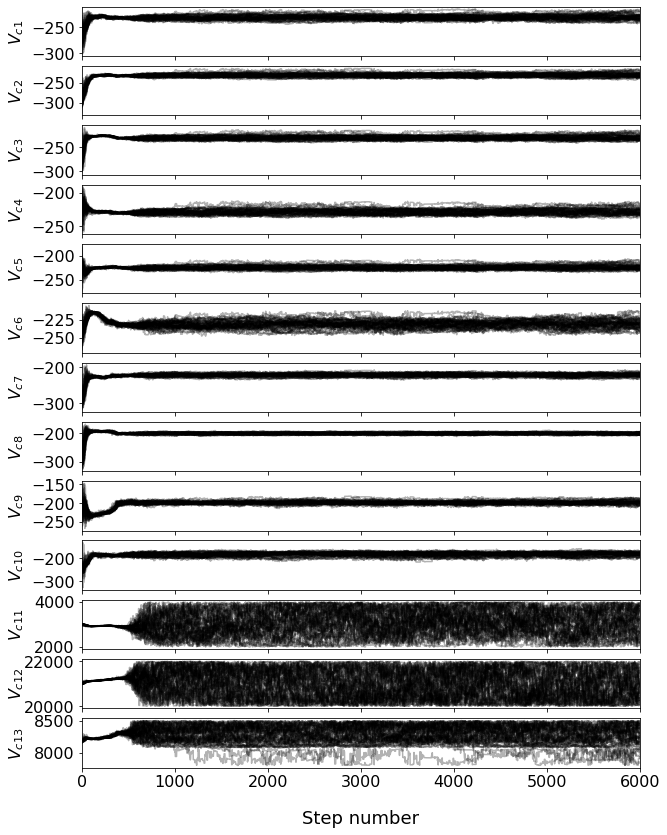

In [42]:
plot_walkers(samplers[-1], 0)

R, v_c, sig-, sig+
6.98 224.2 6.4 4.8
8.93 226.6 6.5 4.8
10.88 224.3 5.6 4.5
12.82 222.5 5.4 4.5
14.78 216.7 6.1 4.5
16.73 224.7 7.2 5.5
18.68 219.5 5.0 4.8
20.62 199.1 3.5 3.2
22.58 190.7 5.6 5.2
24.52 179.5 7.5 7.4
[[-224.24409824    6.41307217    4.78554229]
 [-226.6218472     6.48494816    4.81475503]
 [-224.27322929    5.64328455    4.54186103]
 [-222.50170877    5.35373075    4.48392182]
 [-216.71790999    6.05506998    4.52987632]
 [-224.69822674    7.19496465    5.5299867 ]
 [-219.51907186    5.02828428    4.7567501 ]
 [-199.13056646    3.47766461    3.18853861]
 [-190.72563795    5.57533176    5.15681849]
 [-179.49141438    7.48874054    7.37207677]]
[-224.24409824 -226.6218472  -224.27322929 -222.50170877 -216.71790999
 -224.69822674 -219.51907186 -199.13056646 -190.72563795 -179.49141438]
LinregressResult(slope=-0.002426506690160001, intercept=251.00985145760907, rvalue=-0.8538647035091955, pvalue=0.0016662230457853897, stderr=0.0005229546375105359)
(10,)
(10,)
R, v_c, sig-,

(array([ 7391.57303371,  9318.24936571, 11244.92569772, 13171.60202972,
        15098.27836173, 17024.95469373, 18951.63102573, 20878.30735774,
        22804.98368974, 24731.66002175]),
 array([[-230.74473535,    4.8060163 ,    4.81689745],
        [-230.75703553,    4.53211553,    4.86889639],
        [-229.85158303,    4.39387041,    4.58516519],
        [-228.21268503,    4.37387525,    4.31173177],
        [-224.12449804,    4.38446529,    4.74058182],
        [-230.57063053,    5.93019405,    5.42196432],
        [-221.592878  ,    4.59019296,    4.4777075 ],
        [-200.05051648,    4.034857  ,    3.57463336],
        [-198.50487966,    4.3064968 ,    4.23987255],
        [-181.28221147,   10.69698947,    7.19734384]]))

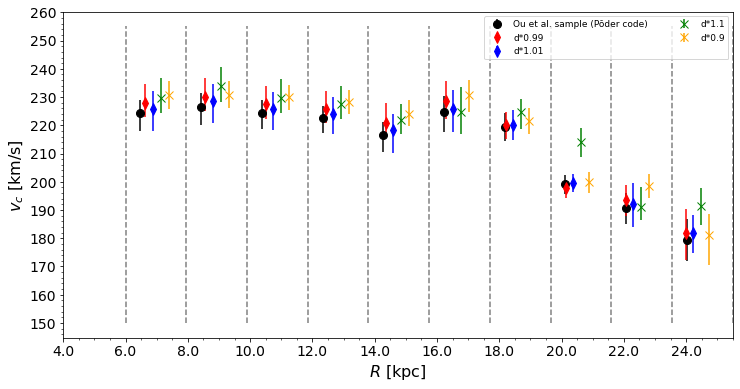

In [45]:
# Ou et al. sample (Poder code ) VS Poder et al. (2023)

extra_dims = [3, 3, 3, 3, 3]
result_name_1 = 'Ou et al. sample (Põder code)'
result_name_2 = 'd*0.99'
result_name_3 = 'd*1.01'
result_name_4 = 'd*1.1'
result_name_5 = 'd*0.9'

#paths[0], paths[1], paths[2],  paths[3]

plot_rotation_curve(paths, 
                    [result_name_1, result_name_2, result_name_3, result_name_4, result_name_5],
                    [2000, 2000, 2000, 2000, 2000],
                    extra_dims=extra_dims,
                    display_eilers=False, 
                    display_bin_edges=True)

#plt.savefig("Poder_VS_Ou_sample_our_code.pdf", format='pdf', dpi=300, bbox_inches='tight')

In [24]:
np.linspace(-100, 100,3)

array([-100.,    0.,  100.])

## Figure 2: Delta Unc Plots

In [6]:
# Curves from literature

headers = ['R', 'v_c', 'sig']
cepheids_pm_method = pd.read_csv("../others_curves/cepheids_ablimit_1.dat", sep='  ', names=headers, skiprows=2, engine='python')
cepheids_vel_method = pd.read_csv("../others_curves/cepheids_ablimit_2.dat", sep='  ', names=headers, skiprows=2,  engine='python')
vc_data_wang = pd.read_csv("../others_curves/vcdata_wang+2022.dat", sep='  ', names=headers, skiprows=3, engine='python')
vc_zhou = pd.read_csv("../others_curves/vc_zhou_etal.csv", sep=' ', names=headers, skiprows=0, index_col=False, engine='python')

headers = ['R', 'v_c', 'sig_below', 'sig_above']
eilers_rc = pd.read_csv("../others_curves/Eilers_RC_Data.csv", sep=' ', names=headers)
ou_rc = pd.read_csv("/home/sven/repos/gaia-tools/jupyter-notebook/others_curves/vc_Ou.csv", sep=',')

other_curves_dict = {'Ou et al. 2023': ou_rc}

/home/sven/repos/dspn/dspn_env/lib64/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


R, v_c, sig-, sig+
6.98 224.2 6.4 4.8
8.93 226.6 6.5 4.8
10.88 224.3 5.6 4.5
12.82 222.5 5.4 4.5
14.78 216.7 6.1 4.5
16.73 224.7 7.2 5.5
18.68 219.5 5.0 4.8
20.62 199.1 3.5 3.2
22.58 190.7 5.6 5.2
24.52 179.5 7.5 7.4
[[-224.24409824    6.41307217    4.78554229]
 [-226.6218472     6.48494816    4.81475503]
 [-224.27322929    5.64328455    4.54186103]
 [-222.50170877    5.35373075    4.48392182]
 [-216.71790999    6.05506998    4.52987632]
 [-224.69822674    7.19496465    5.5299867 ]
 [-219.51907186    5.02828428    4.7567501 ]
 [-199.13056646    3.47766461    3.18853861]
 [-190.72563795    5.57533176    5.15681849]
 [-179.49141438    7.48874054    7.37207677]]
[-224.24409824 -226.6218472  -224.27322929 -222.50170877 -216.71790999
 -224.69822674 -219.51907186 -199.13056646 -190.72563795 -179.49141438]
LinregressResult(slope=-0.002426506690160001, intercept=251.00985145760907, rvalue=-0.8538647035091955, pvalue=0.0016662230457853897, stderr=0.0005229546375105359)
(10,)
(10,)
R, v_c, sig-,

/home/sven/repos/dspn/dspn_env/lib64/python3.6/site-packages/ipykernel_launcher.py:170: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


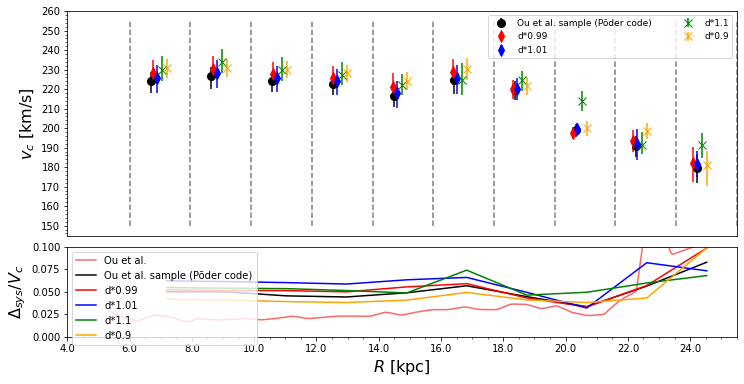

In [41]:
# Ou et al. VS Ou et al. sample (Poder code )


extra_dims = [3, 3, 3, 3, 3]
result_name_1 = 'Ou et al. sample (Põder code)'
result_name_2 = 'd*0.99'
result_name_3 = 'd*1.01'
result_name_4 = 'd*1.1'
result_name_5 = 'd*0.9'


x, y =plot_rotation_curve_delta_unc(paths, 
                     [result_name_1, result_name_2, result_name_3, result_name_4, result_name_5],
                    [2000, 2000, 2000, 2000, 2000],
                    extra_dims=extra_dims,
                    display_eilers=False, 
                    display_bin_edges=True)
#plt.savefig("Ou_VS_Ou_sample_our_code.pdf", format='pdf', dpi=300, bbox_inches='tight')

## Corner plot for Ou et al. sample

In [57]:
from _corner import corner
from scipy.stats import gaussian_kde

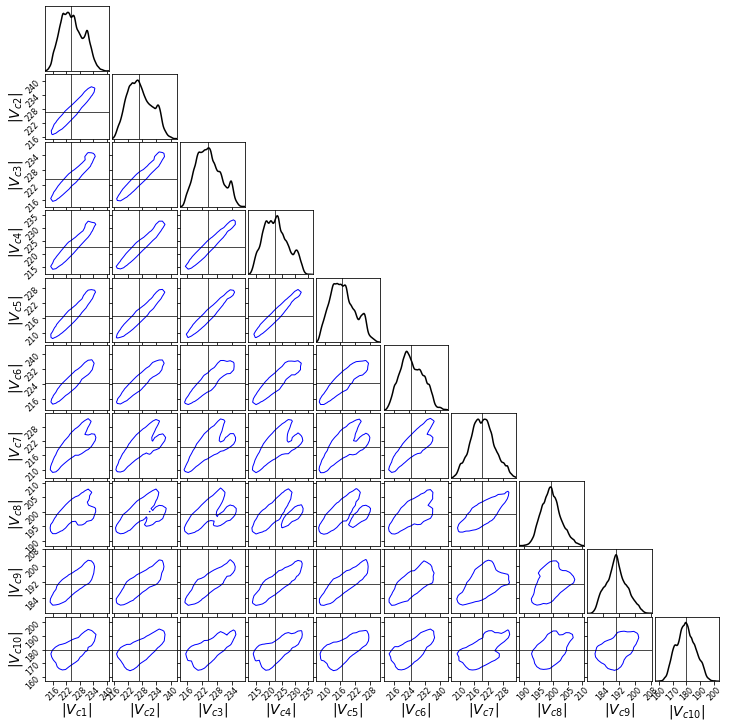

In [61]:
xdf = np.arange(0,10,1)
theta_labels = [r'$|V_{c%s}|$' %str(i+1) for i in xdf]

burn_in = 2000
path = samplers[0]
reader = emcee.backends.HDFBackend(path, read_only=True)
flatchain = reader.get_chain(flat=True, discard = burn_in)
flatchain = flatchain[:, 0:10]
flatchain=np.abs(flatchain)
v_med = np.median(flatchain, 0)

fig, axes =corner(flatchain, plot_datapoints = False,  
                  title_kwargs={"fontsize": 15},
                  levels=(0, 1-np.exp(-2)), 
                   labels=theta_labels,
                    plot_density = False, 
                    fill_countours = False,
                    smooth = 0.5, 
                    color='blue')





from scipy.stats import gaussian_kde

# plot KDE smoothed version of 1D marginalised distributions

for axidx, samps in zip(np.arange(0, 10*10, 11), flatchain.T):

    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim(); 

    xvals = np.linspace(xvals[0], xvals[1], 100)
    yvals =  kde(xvals)
    fig.axes[axidx].plot(xvals, yvals/np.max(yvals), color="black", lw=1.5) 
    
    # the division by np.max(kde(xvals)) is what normalises the 1D curves
y_label_idx = np.arange(10, 101, 10)
x_label_idx = np.arange(90, 100, 1)
for i, ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=8)

    if(i in y_label_idx):
        ax.set_ylabel(theta_labels[int(i/10)], fontsize=14, labelpad=20)
        ax.tick_params(axis='both', labelsize=8, pad=0)
    if(i in x_label_idx):
        ax.tick_params(axis='both', labelsize=8, pad=0)
        ax.set_xlabel(theta_labels[i%90], fontsize=14, labelpad=10)

    if(i==99):
        ax.set_xlabel(theta_labels[i%90], fontsize=14, labelpad=0)

ndim = 10

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(v_med[i], color="black", lw=0.7)

for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(v_med[xi], color="black", lw=0.7)
        ax.axhline(v_med[yi], color="black", lw=0.7)
        ax.plot(v_med[xi], v_med[yi], "black")


#plt.savefig("corner_all_runs.pdf", format='pdf', dpi=300, bbox_inches='tight')



(192000, 13)


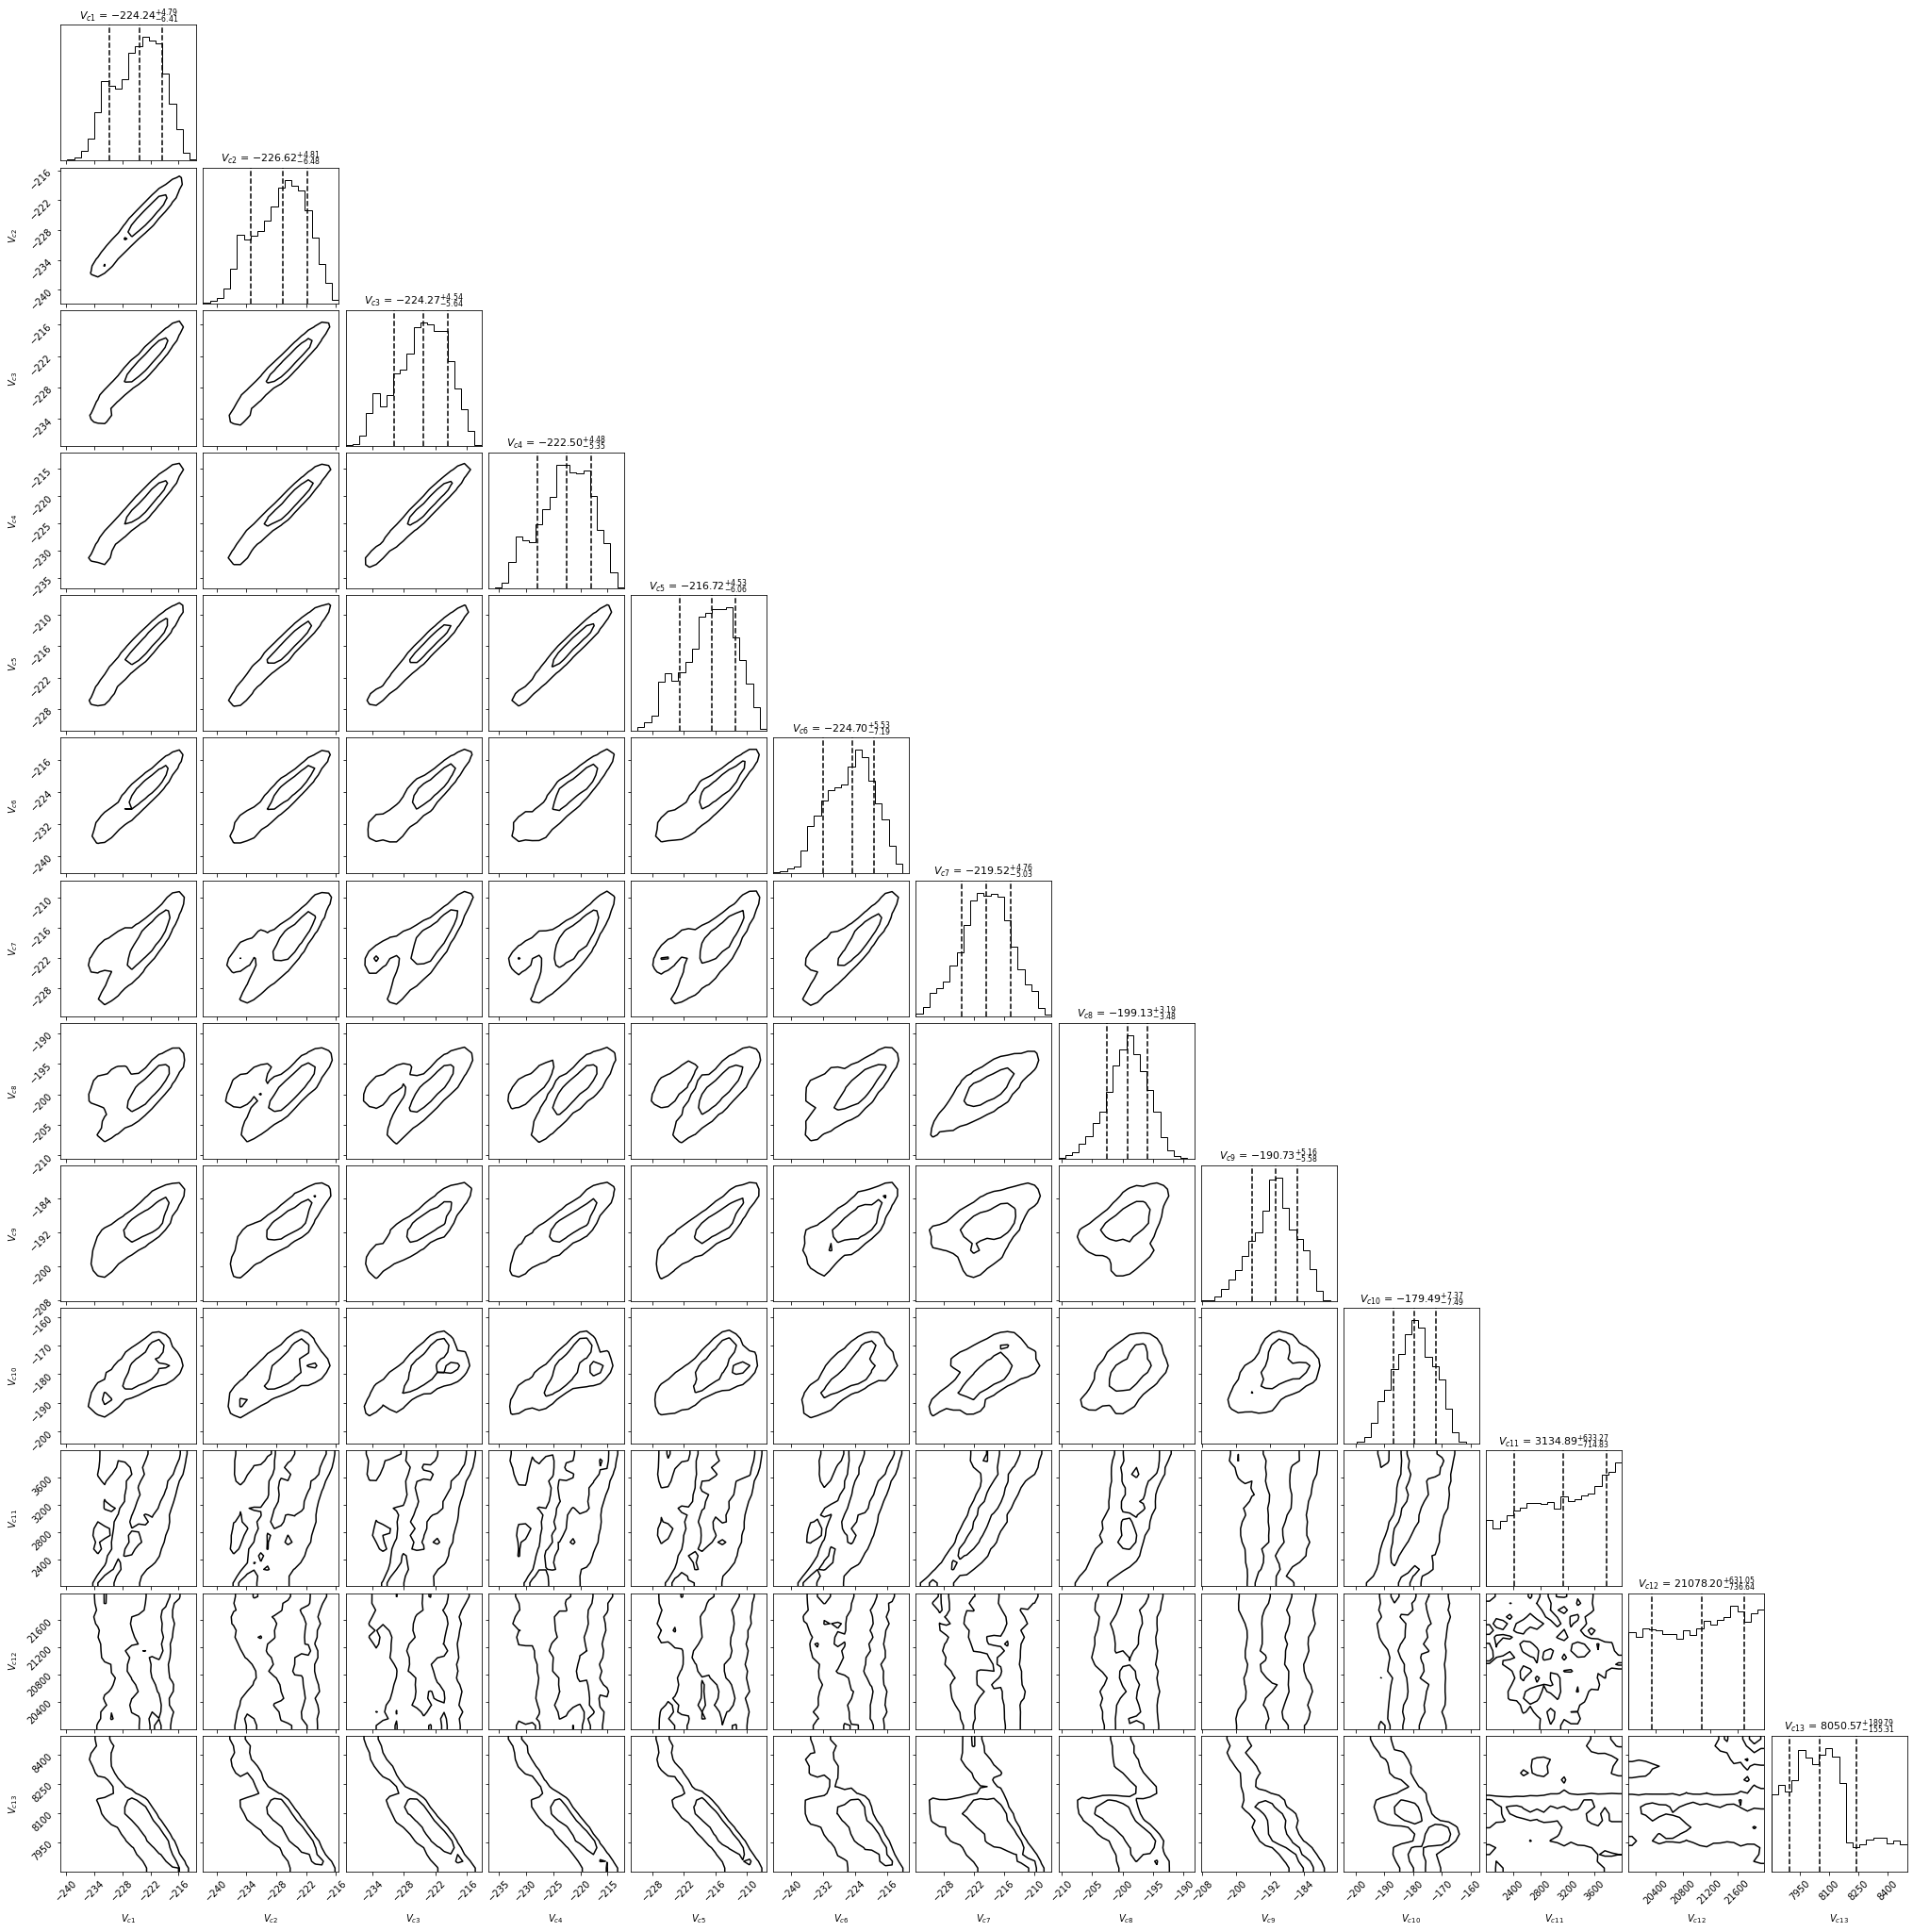

In [62]:
plot_corner(samplers[0], burn_in = 2000)